#### Neccesary Imports

In [28]:
# Visualization Imports

import networkx as nx
import matplotlib.pyplot as plt

# Torch and pyG imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

# Also Useful

from random import choice
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#### Downloading the Dataset

In [29]:
MUTAG = TUDataset(
    root=r'C:\Users\Homelander\Desktop\ANN Phase (2)',
    name='MUTAG'
)

#### Splitting MUTAG to train-test

In [30]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(MUTAG, test_size=0.2, random_state=42)

#### EDA, Domain Knowledge, and visualization on the training data

In [31]:
atoms = {
    0: 'C', 
    1: 'N', 
    2: 'O', 
    3: 'F', 
    4: 'I', 
    5: 'Cl', 
    6: 'Br'
    }

In [32]:
bonds = {
    0: 'aromatic', 
    1: 'single', 
    2: 'double', 
    3: 'triple'
    }

In [33]:
def get_labels(graph):
    """
    function decodes the one-hot-encoded features to return
    both node labels(atoms' names) and edges' labels which is basically
    the chemical bonds between atoms in a molecule.

    input: graph
    output: chemical formula representation,
            the nodes labels,
            the edges labels

    """

    node_labels = [atoms[i.item()] for i in graph.x.argmax(dim=1)]
    edge_labels = [bonds[i.item()] for i in graph.edge_attr.argmax(dim=1)]

    node_labels = {f'Node {i}': label for i, label in enumerate(node_labels)}
    edge_labels = {f'Edge {i}': label for i, label in enumerate(edge_labels)}

    occurrences = Counter(node_labels.values())  
    chemical_formula = ''.join(
        [f"{atom}{occurrences[atom] if occurrences[atom] != 1 else ''}" for atom in occurrences]
    )

    return chemical_formula, node_labels, edge_labels

In [34]:
"""
function plots the graph after decoding its node and edge labels
to their authentic labels, instead of encoded 0s and 1s, it tells
the atoms name and the bond type, ex: Iodine, Nitrogen, and Aromatic bond.
input: graph, title (optional), node_color (optional), edge_color (optional)
output: None, just plots the graph

""" 

def plot_graph(graph, title = f'', node_color = 'lightgreen', edge_color = 'black') -> None:
     
    G = nx.Graph()
    
    edge_indices = graph.edge_index.cpu().numpy()
    for i in range(edge_indices.shape[1]):
            G.add_edge(
                edge_indices[0][i].item(), 
                edge_indices[1][i].item()
                )  

    
    pos = nx.spring_layout(G, k = 0.5)  
    plt.figure(figsize=(8, 6))

    nodes_color = [node_color] * graph.num_nodes

    nx.draw(
         G, 
         pos, 
         with_labels = False, 
         node_size = 500, 
         node_color = nodes_color, 
         font_weight = 'bold'
         )
    
    
    nodes_label = {i: atoms[graph.x[i].argmax().item()] for i in range(graph.num_nodes)}
    for node, label in nodes_label.items():
        plt.text(
             pos[node][0], 
             pos[node][1] + 0.1, 
             label, 
             fontsize = 10, 
             ha = 'center')

    for i, (u, v) in enumerate(G.edges()):
        plt.plot(
             *zip(pos[u], pos[v]), 
             color = edge_color, 
             linewidth=2
             )
        
    for i, (u, v) in enumerate(G.edges()):
        mid_x = (pos[u][0] + pos[v][0]) / 2
        mid_y = (pos[u][1] + pos[v][1]) / 2
        edge_label = bonds[graph.edge_attr[i].argmax().item()]
        plt.text(
             mid_x, 
             mid_y, 
             edge_label, 
             fontsize = 8, 
             ha = 'center', 
             color = 'black', 
             bbox = dict(
                  facecolor = 'white', 
                  alpha = 0.7, 
                  edgecolor = 'none'
                    )
            )

    plt.title(title)
    plt.show()

In [35]:
graph_class_0 = choice([graph for graph in MUTAG if graph.y.item() == 0])
graph_class_1 = choice([graph for graph in MUTAG if graph.y.item() == 1])

chemical_info_class_0, node_info_class_0, edge_info_class_0 = get_labels(graph_class_0)
chemical_info_class_1, node_info_class_1, edge_info_class_1 = get_labels(graph_class_1)

graph0 = {
    'Formula of graph class 0': chemical_info_class_0
}

graph1 = {
    'Formula of graph class 1': chemical_info_class_1 
}

print(graph0, graph1)

{'Formula of graph class 0': 'C8N3O2'} {'Formula of graph class 1': 'C6N2O4'}


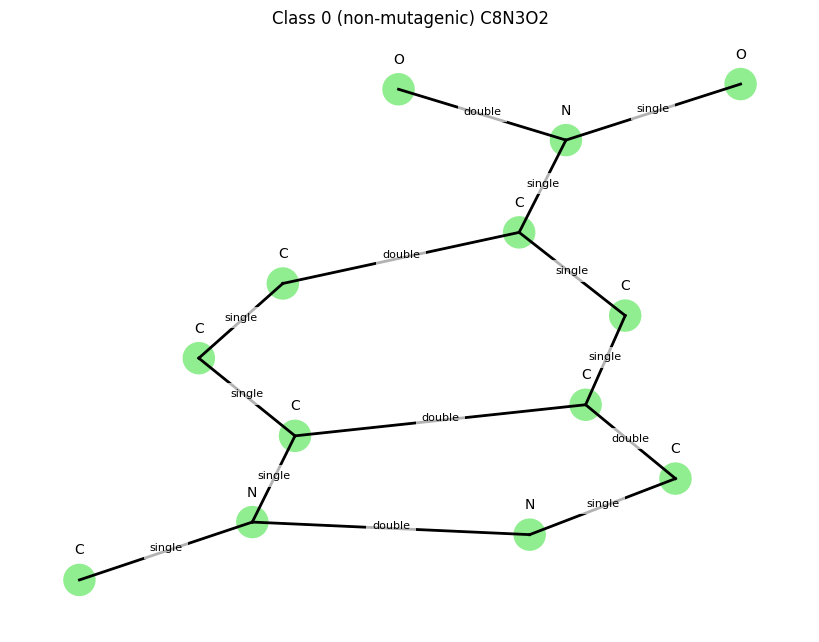

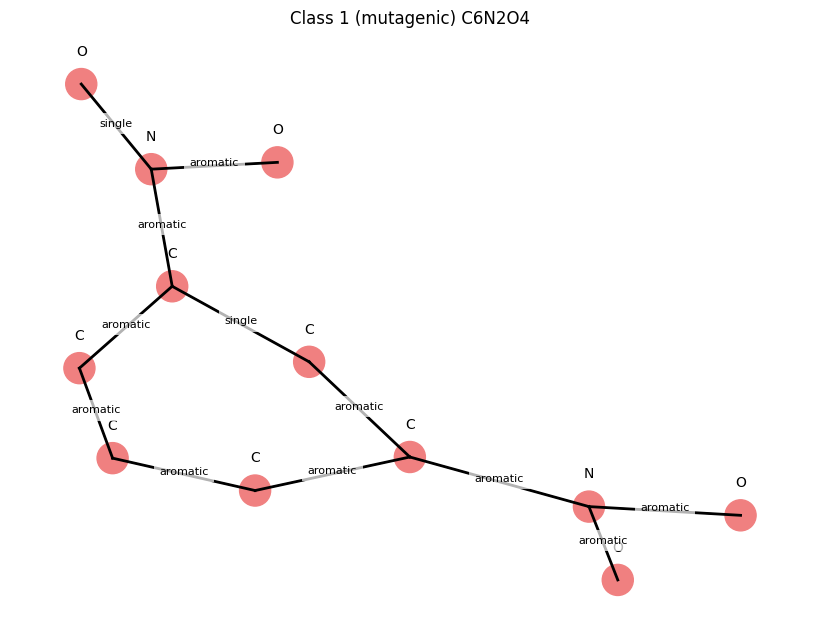

In [36]:
plot_graph(graph_class_0, title = f"Class 0 (non-mutagenic) {chemical_info_class_0}", node_color = 'lightgreen')
plot_graph(graph_class_1, title = f"Class 1 (mutagenic) {chemical_info_class_1}", node_color = 'lightcoral')

#### Normalizing features

In [37]:
feature_normalizer = NormalizeFeatures()

for graph in range(len(train_data)):
    train_data[graph] = feature_normalizer(train_data[graph])

#### Creating the dataloaders

In [38]:
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

#### Implementing base class for GNNs

In [39]:
class GNN(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, dropout_rate=0.5):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.output_channels = output_channels
        self.dropout_rate = dropout_rate  
        self.fc = nn.Linear(hidden_channels, output_channels)

    def forward(self, x, edge_indices, batch):
        pass 

    def FullyConnectedlayerWithGlobalPooling(self, x, batch):
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

#### Implementing GCN(Graph Convulutional Network)

In [40]:
class GCN(GNN):
    def __init__(self, input_channels, hidden_channels, output_channels, dropout_rate=0.5):
        super().__init__(input_channels, hidden_channels, output_channels, dropout_rate)  
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.batch_norm1 = nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = nn.BatchNorm1d(hidden_channels)

    def forward(self, x, edge_indices, batch):
        x = F.leaky_relu(self.batch_norm1(self.conv1(x, edge_indices)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)  
        x = F.leaky_relu(self.batch_norm2(self.conv2(x, edge_indices)))
        return self.FullyConnectedlayerWithGlobalPooling(x, batch)

#### Implementing GraphSAGE(Graph Sample and Aggregate)

In [41]:
class GraphSAGE(GNN):
    def __init__(self, input_channels, hidden_channels, output_channels, dropout_rate=0.5):
        super().__init__(input_channels, hidden_channels, output_channels, dropout_rate)  
        self.conv1 = SAGEConv(input_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.batch_norm1 = nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = nn.BatchNorm1d(hidden_channels)

    def forward(self, x, edge_indices, batch):  
        x = F.leaky_relu(self.batch_norm1(self.conv1(x, edge_indices)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)  
        x = F.leaky_relu(self.batch_norm2(self.conv2(x, edge_indices)))
        return self.FullyConnectedlayerWithGlobalPooling(x, batch)

#### Intializing the models

In [42]:
GraphConvolutionNetwork = GCN(
    input_channels = MUTAG.num_features,
    hidden_channels = 256,
    output_channels = MUTAG.num_classes,
    dropout_rate = 0.3
)

In [43]:
GraphSAGEModel = GraphSAGE(
    input_channels = MUTAG.num_features,
    hidden_channels = 256,
    output_channels = MUTAG.num_classes
)

#### Intializing the optimizers with random learning rate and weight decay

In [45]:
GCNoptimizer = optim.Adam(GraphConvolutionNetwork.parameters(), lr=0.01, weight_decay=5e-4)
GraphSAGEoptimizer = optim.Adam(GraphSAGEModel.parameters(), lr=0.01, weight_decay=5e-4)

In [46]:
criterion = nn.CrossEntropyLoss()

#### Implementing the training and testing functions

In [47]:
def train(model, optimizer):
    model.train() 
    total_loss = 0
    correct = 0
    total = 0
    
    for data in train_data_loader:
        optimizer.zero_grad()
        x, edge_index, y, batch = data.x, data.edge_index, data.y, data.batch
        out = model(x, edge_index, batch)  
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    
    accuracy = correct / total
    return total_loss / len(train_data_loader), accuracy

def test(model):
    model.eval()  
    correct = 0
    total = 0
    all_preds = []  
    all_labels = []  
    
    with torch.no_grad():
        for data in test_data_loader:
            x, edge_index, y, batch = data.x, data.edge_index, data.y, data.batch
            out = model(x, edge_index, batch)  
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())  
            all_labels.extend(y.cpu().numpy())  
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    
    accuracy = correct / total
    return accuracy, all_labels, all_preds 

#### Traing and Testing the Graph Convolution Network

In [48]:
num_epochs = 100
best_acc = 0

for epoch in range(1, num_epochs + 1):
    loss, train_acc = train(GraphConvolutionNetwork, GCNoptimizer)
    test_acc, true_labels_gcn, predicted_labels_gcn = test(GraphConvolutionNetwork)  # Ensure this line is correct
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc * 100:.2f}%, Test Acc: {test_acc * 100:.2f}%')
    
    if test_acc > best_acc:
        best_acc = test_acc
       

print(f'Best Test Accuracy: {best_acc * 100:.2f}%')


Epoch: 001, Loss: 0.7027, Train Acc: 67.33%, Test Acc: 68.42%
Epoch: 002, Loss: 0.5377, Train Acc: 73.33%, Test Acc: 81.58%
Epoch: 003, Loss: 0.5455, Train Acc: 73.33%, Test Acc: 31.58%
Epoch: 004, Loss: 0.5283, Train Acc: 72.67%, Test Acc: 31.58%
Epoch: 005, Loss: 0.5180, Train Acc: 76.00%, Test Acc: 31.58%
Epoch: 006, Loss: 0.5495, Train Acc: 75.33%, Test Acc: 31.58%
Epoch: 007, Loss: 0.5084, Train Acc: 74.67%, Test Acc: 31.58%
Epoch: 008, Loss: 0.5310, Train Acc: 76.00%, Test Acc: 31.58%
Epoch: 009, Loss: 0.5162, Train Acc: 76.00%, Test Acc: 71.05%
Epoch: 010, Loss: 0.5223, Train Acc: 74.67%, Test Acc: 84.21%
Epoch: 011, Loss: 0.5670, Train Acc: 72.67%, Test Acc: 84.21%
Epoch: 012, Loss: 0.5391, Train Acc: 77.33%, Test Acc: 78.95%
Epoch: 013, Loss: 0.5126, Train Acc: 76.00%, Test Acc: 81.58%
Epoch: 014, Loss: 0.5349, Train Acc: 73.33%, Test Acc: 76.32%
Epoch: 015, Loss: 0.5515, Train Acc: 74.00%, Test Acc: 78.95%
Epoch: 016, Loss: 0.5151, Train Acc: 74.00%, Test Acc: 81.58%
Epoch: 0

In [49]:
num_epochs = 100
best_acc = 0

for epoch in range(1, num_epochs + 1):
    loss, train_acc = train(GraphSAGEModel, GraphSAGEoptimizer)
    test_acc, true_labels_sage, predicted_labels_sage = test(GraphSAGEModel)  # Ensure this line is correct
    
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc * 100:.2f}%, Test Acc: {test_acc * 100:.2f}%')
    
    if test_acc > best_acc:
        best_acc = test_acc
        

print(f'Best Test Accuracy: {best_acc * 100:.2f}%')

Epoch: 001, Loss: 0.6495, Train Acc: 60.67%, Test Acc: 68.42%
Epoch: 002, Loss: 0.5670, Train Acc: 74.67%, Test Acc: 68.42%
Epoch: 003, Loss: 0.5395, Train Acc: 76.67%, Test Acc: 68.42%
Epoch: 004, Loss: 0.5497, Train Acc: 71.33%, Test Acc: 71.05%
Epoch: 005, Loss: 0.5311, Train Acc: 78.67%, Test Acc: 71.05%
Epoch: 006, Loss: 0.5264, Train Acc: 77.33%, Test Acc: 71.05%
Epoch: 007, Loss: 0.5426, Train Acc: 74.00%, Test Acc: 73.68%
Epoch: 008, Loss: 0.5216, Train Acc: 79.33%, Test Acc: 81.58%
Epoch: 009, Loss: 0.5447, Train Acc: 74.67%, Test Acc: 81.58%
Epoch: 010, Loss: 0.5496, Train Acc: 72.00%, Test Acc: 84.21%
Epoch: 011, Loss: 0.5474, Train Acc: 71.33%, Test Acc: 78.95%
Epoch: 012, Loss: 0.5235, Train Acc: 74.00%, Test Acc: 78.95%
Epoch: 013, Loss: 0.5228, Train Acc: 75.33%, Test Acc: 81.58%
Epoch: 014, Loss: 0.5141, Train Acc: 75.33%, Test Acc: 84.21%
Epoch: 015, Loss: 0.5662, Train Acc: 72.00%, Test Acc: 84.21%
Epoch: 016, Loss: 0.5851, Train Acc: 74.67%, Test Acc: 81.58%
Epoch: 0

In [50]:

from sklearn.metrics import classification_report, confusion_matrix
print("GCN Classification Report:")
print(classification_report(true_labels_gcn, predicted_labels_gcn))

print("GCN Confusion Matrix:")
print(confusion_matrix(true_labels_gcn, predicted_labels_gcn))

print("GraphSAGE Classification Report:")
print(classification_report(true_labels_sage, predicted_labels_sage))

print("GraphSAGE Confusion Matrix:")
print(confusion_matrix(true_labels_sage, predicted_labels_sage))

GCN Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.96      0.85      0.90        26

    accuracy                           0.87        38
   macro avg       0.84      0.88      0.86        38
weighted avg       0.89      0.87      0.87        38

GCN Confusion Matrix:
[[11  1]
 [ 4 22]]
GraphSAGE Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.88      0.88      0.88        26

    accuracy                           0.84        38
   macro avg       0.82      0.82      0.82        38
weighted avg       0.84      0.84      0.84        38

GraphSAGE Confusion Matrix:
[[ 9  3]
 [ 3 23]]


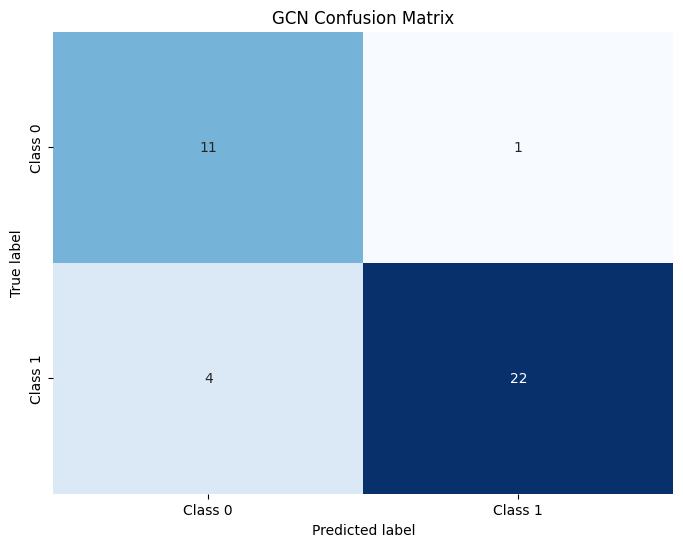

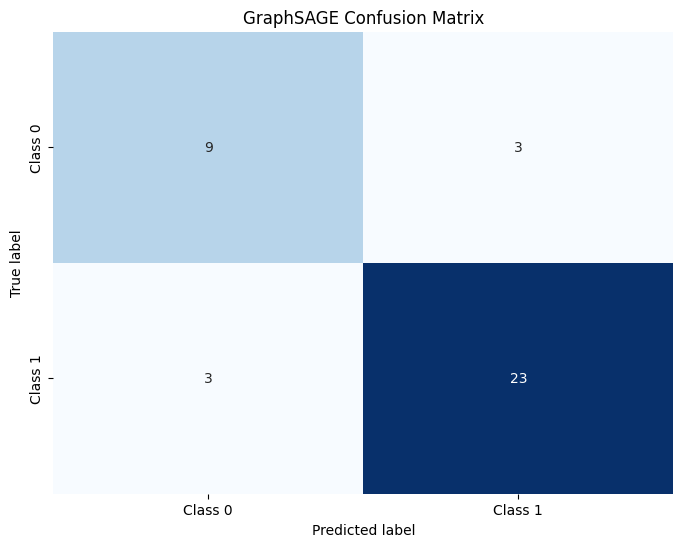

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm_gcn = confusion_matrix(true_labels_gcn, predicted_labels_gcn)
cm_sage = confusion_matrix(true_labels_sage, predicted_labels_sage)

plot_confusion_matrix(cm_gcn, title='GCN Confusion Matrix')
plot_confusion_matrix(cm_sage, title='GraphSAGE Confusion Matrix')


### Hyperparameter Tuning for GCN

In [52]:
import torch
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

best_model = None
best_accuracy = 0
best_params = None

param_grid = {
    'hidden_channels': [64, 128, 256],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.001],
    'weight_decay': [0, 1e-4]
}

grid = ParameterGrid(param_grid)

best_model = None
best_accuracy = 0

for params in grid:
    print(f"Training with parameters: {params}")
    
    model = GCN(
        input_channels=MUTAG.num_features,
        hidden_channels=params['hidden_channels'],
        output_channels=MUTAG.num_classes,
        dropout_rate=params['dropout_rate']
    )
    
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, optimizer)
        val_acc, _, _ = test(model)  
    
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = model
        best_params = params 

print(f"Best model achieved validation accuracy: {best_accuracy}")
print(f"Best parameters: {best_params}")  

Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 64, 'learning_rate': 0.01, 'weight_decay': 0}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 64, 'learning_rate': 0.01, 'weight_decay': 0.0001}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 64, 'learning_rate': 0.001, 'weight_decay': 0}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 64, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 128, 'learning_rate': 0.01, 'weight_decay': 0}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 128, 'learning_rate': 0.01, 'weight_decay': 0.0001}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 128, 'learning_rate': 0.001, 'weight_decay': 0}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 128, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 2

0.8947368421052632
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.89      0.96      0.93        26

    accuracy                           0.89        38
   macro avg       0.90      0.86      0.87        38
weighted avg       0.90      0.89      0.89        38



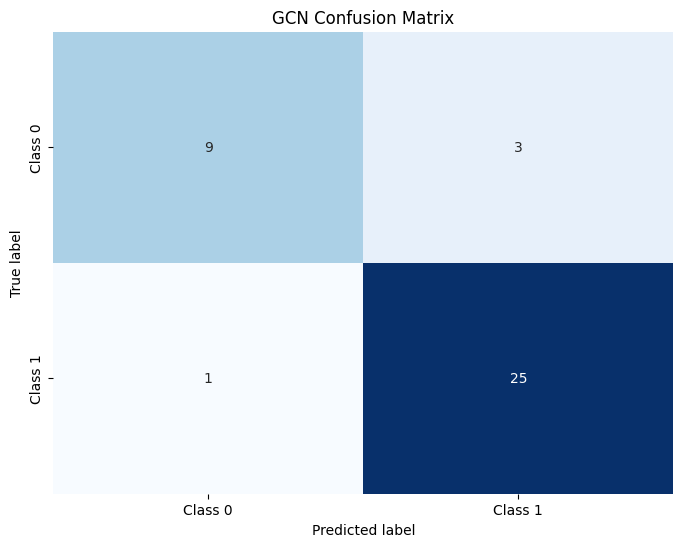

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_acc, y_true, y_pred = test(best_model)  

report = classification_report(y_true, y_pred)
print(test_acc)
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, title='GCN Confusion Matrix')



In [54]:
import torch
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

best_model = None
best_accuracy = 0
best_params = None  
param_grid = {
    'hidden_channels': [64, 128, 256],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.001],
    'weight_decay': [0, 1e-4]
}

grid = ParameterGrid(param_grid)

best_model = None
best_accuracy = 0

for params in grid:
    print(f"Training with parameters: {params}")
    
    model = GraphSAGE(
        input_channels=MUTAG.num_features,
        hidden_channels=params['hidden_channels'],
        output_channels=MUTAG.num_classes,
        dropout_rate=params['dropout_rate']
    )
        
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, optimizer)
        val_acc, _, _ = test(model)  
    
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = model
        best_params = params 
print(f"Best model achieved validation accuracy: {best_accuracy}")
print(f"Best parameters: {best_params}")  

Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 64, 'learning_rate': 0.01, 'weight_decay': 0}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 64, 'learning_rate': 0.01, 'weight_decay': 0.0001}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 64, 'learning_rate': 0.001, 'weight_decay': 0}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 64, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 128, 'learning_rate': 0.01, 'weight_decay': 0}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 128, 'learning_rate': 0.01, 'weight_decay': 0.0001}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 128, 'learning_rate': 0.001, 'weight_decay': 0}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 128, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Training with parameters: {'dropout_rate': 0.3, 'hidden_channels': 2

0.8947368421052632
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.89      0.96      0.93        26

    accuracy                           0.89        38
   macro avg       0.90      0.86      0.87        38
weighted avg       0.90      0.89      0.89        38



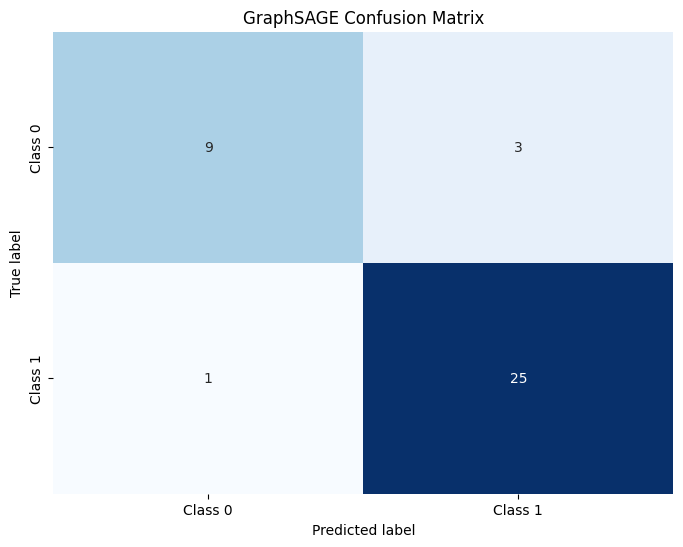

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

test_acc, y_true, y_pred = test(best_model)  

report = classification_report(y_true, y_pred)
print(test_acc)
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, title='GraphSAGE Confusion Matrix')